数据集与数据加载器
======================


处理数据样本的代码可能很混乱且难以维护；理想情况下，我们希望将数据集代码与模型训练代码分离，以提高可读性和模块化。PyTorch 提供了两个数据基本类型：torch.utils.data.DataLoader 和 torch.utils.data.Dataset，它们使您可以使用预加载的数据集以及您自己的数据。Dataset 存储样本及其对应的标签，DataLoader 在 Dataset 周围包装一个可迭代对象，以方便访问样本。

PyTorch 领域库提供了许多预加载的数据集（例如 FashionMNIST），这些数据集是 torch.utils.data.Dataset 的子类，并实现了特定于该数据的函数。它们可以用于对模型进行原型设计和基准测试。您可以在以下位置找到它们：[图像数据集](https://pytorch.org/vision/stable/datasets.html), [文本数据集](https://pytorch.org/text/stable/datasets.html), and [音频数据集](https://pytorch.org/audio/stable/datasets.html)


加载数据集
=================

以下是如何从 TorchVision 加载 Fashion-MNIST 数据集的示例。Fashion-MNIST 是一个 Zalando 服装图像数据集，包含 60,000 个训练样本和 10,000 个测试样本。每个样本包含一个 28×28 的灰度图像，以及一个与 10 个类别中的一个相关的标签。

我们使用以下参数加载 FashionMNIST 数据集

:   -   `root` 是存放训练/测试数据的路径。
    -   `train` 指定训练或测试数据集。
    -   `download=True` 如果 root 中没有数据，则从互联网下载数据。
    -   `transform` and `target_transform` 指定特征和标签转换。


In [1]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root='../data',
    train=True,
    download=True,
    transform=ToTensor() # 将图片转为 PyTorch 张量, 同时，将像素值从 [0, 255] 范围归一化为 [0, 1] 范围（浮点数）。
)

test_data = datasets.FashionMNIST(
    root='../data',
    train=False,
    download=True,
    transform=ToTensor() # 将图片转为 PyTorch 张量, 同时，将像素值从 [0, 255] 范围归一化为 [0, 1] 范围（浮点数）。
)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



迭代和可视化数据集
=====================================

我们可以像列表一样手动索引 Datasets：training_data[index]。我们使用 matplotlib 来可视化训练数据中的部分样本。


torch.Size([28, 28])

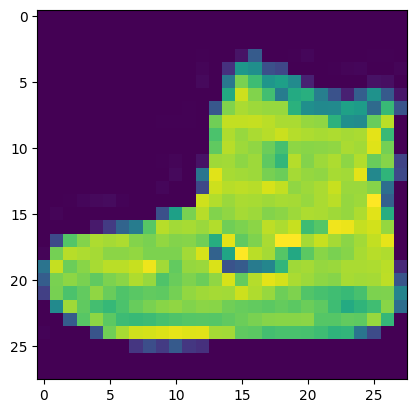

In [15]:
training_data # 迭代器

img,label = training_data[0]
img = img.squeeze() # shape = 1,28,28,灰度图，显示的时候要去掉1
plt.imshow(img) # 
label
img.shape

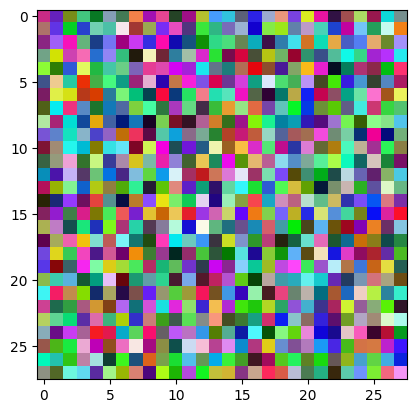

torch.Size([28, 28, 3])

In [4]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]

test = torch.rand(28,28,3,dtype=torch.float)
plt.imshow(test)
plt.show()
test.shape

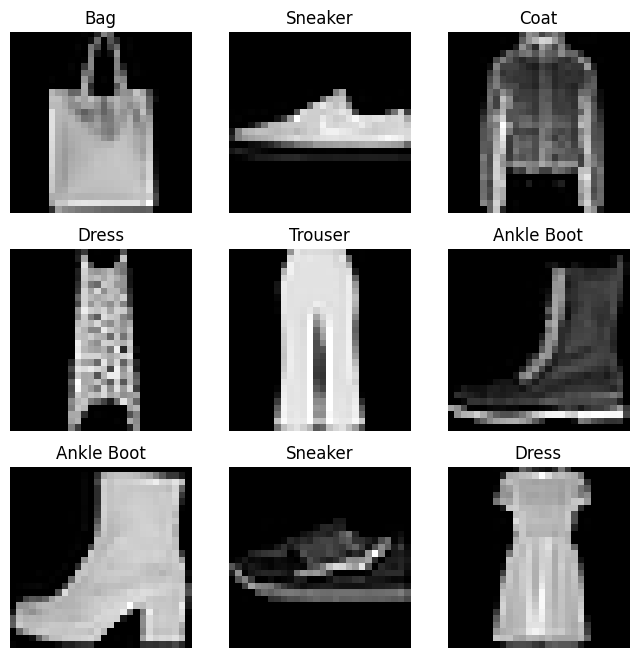

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

------------------------------------------------------------------------


为您的文件创建自定义数据集
========================================

自定义 Dataset 类必须实现三个函数：
[\_\_init\_\_]{.title-ref}, [\_\_len\_\_]{.title-ref}, and
[\_\_getitem\_\_]{.title-ref}. 请看此实现；FashionMNIST 图像存储在目录 img_dir 中，它们的标签单独存储在 CSV 文件 annotations_file 中。




In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # tshirt1.jpg, 0
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

`__init__`
==========

\_\_[init](#init__) 函数在实例化 Dataset 对象时运行一次。我们初始化包含图像的目录、注释文件和两种转换（将在下一节中详细介绍）。

labels.csv 文件的格式如下

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9


In [7]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

`__len__`
=========

函数返回数据集中的样本数量。


In [8]:
def __len__(self):
    return len(self.img_labels)

`__getitem__`
=============

 \_\_[getitem](#getitem__) 函数加载并返回给定索引 idx 处的数据集中的样本。根据索引，它识别图像在磁盘上的位置，使用 read_image 将其转换为张量，从 self.img_labels 中的 csv 数据中检索相应的标签，对它们调用转换函数（如果适用），并将张量图像和相应的标签以元组形式返回。

In [9]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

------------------------------------------------------------------------


使用 DataLoaders 准备您的训练数据
=================================================

Dataset 一次获取数据集的特征和标签。在训练模型时，我们通常希望以“小批量”的形式传递样本，在每个 epoch 中重新洗牌数据以减少模型过拟合，并使用 Python 的 multiprocessing 来加速数据检索。

DataLoader 是一个可迭代对象，它通过一个简单的 API 为我们抽象了这种复杂性。


In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
for imgs,labels in train_dataloader: # i是一个list，其中包含两项，data和label,
    print(imgs.shape,labels.shape) #

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size

遍历 DataLoader
==============================

我们已将该数据集加载到 DataLoader 中，并且可以根据需要遍历该数据集。下面的每次迭代都会返回一批 train_features 和 train_labels（分别包含 batch_size=64 个特征和标签）。因为我们指定了 shuffle=True，所以在我们遍历完所有批次后，数据会进行洗牌（要对数据加载顺序进行更细粒度的控制，请查看 采样器）。


特征shape: torch.Size([64, 1, 28, 28])
标签shape: torch.Size([64])


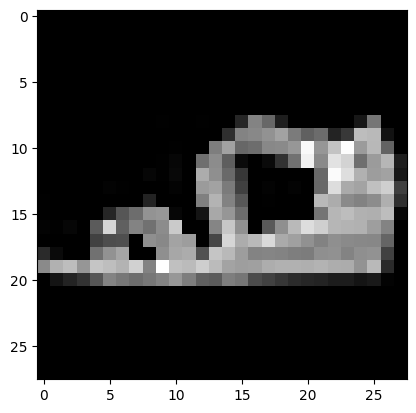

Label: 5


In [11]:
# 展示图片和标签
train_features, train_labels = next(iter(train_dataloader))
print(f"特征shape: {train_features.size()}")
print(f"标签shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

------------------------------------------------------------------------
